In [1]:
import numpy as np

def normalize_data(data, qh_min, qh_max):
  """
  Normalizes data based on the high-fidelity data range (min and max).

  Args:
    data (np.ndarray): The data to normalize (can be scalar or array).
    qh_min (float): The minimum value of the high-fidelity training data (Q_H).
    qh_max (float): The maximum value of the high-fidelity training data (Q_H).

  Returns:
    np.ndarray: The normalized data, scaled to the range  relative to
                the high-fidelity range. Returns NaN if qh_max equals qh_min.
  """
  if qh_max == qh_min:
      # Handle case of zero range to avoid division by zero
      # Option 1: Return 0.5 for all values (midpoint)
      # Option 2: Return 0 for all values
      # Option 3: Raise an error
      # Current implementation: Return NaN or handle as appropriate for the application
      return np.full_like(data, np.nan, dtype=np.float64)
  return (data - qh_min) / (qh_max - qh_min)


In [2]:
def denormalize_data(normalized_data, qh_min, qh_max):
  """
  Denormalizes data that was previously normalized using the high-fidelity range.

  Args:
    normalized_data (np.ndarray): The normalized data (typically model output).
    qh_min (float): The minimum value used for normalization.
    qh_max (float): The maximum value used for normalization.

  Returns:
    np.ndarray: The data denormalized back to the original scale.
  """
  # If data was normalized when qh_min == qh_max (resulting in NaN or fixed value),
  # denormalization might return qh_min or handle based on the normalization choice.
  if qh_max == qh_min:
      # If normalization returned NaN, denormalization might also return NaN
      # or return the constant value qh_min.
      # Let's assume returning qh_min is desired if the range was zero.
      # Check if normalized_data is NaN if that was the normalization output
      if np.any(np.isnan(normalized_data)):
           return np.full_like(normalized_data, np.nan, dtype=np.float64)
      # Otherwise, assume normalization produced a fixed value (e.g., 0 or 0.5)
      # and denormalizing should yield the single HF value.
      return np.full_like(normalized_data, qh_min, dtype=np.float64)

  return normalized_data * (qh_max - qh_min) + qh_min

In [3]:
def compile_input_table(hf_y, hf_q_l, lf_y, lf_q):
    """
    Compiles the structured input table for a single high-fidelity point.

    Args:
        hf_y (float or np.ndarray): Input parameter(s) for the high-fidelity point.
        hf_q_l (float): The *normalized* low-fidelity prediction at hf_y.
        lf_y (np.ndarray): Low-fidelity input parameters. Shape (N_L,) or (N_L, D_y).
        lf_q (np.ndarray): Low-fidelity predictions. Shape (N_L,).

    Returns:
        np.ndarray: The compiled input table, shape (N_L, C).
    """
    # Debug: Print input shapes
    print(f"hf_y: {hf_y}, hf_y shape: {np.shape(hf_y)}")
    print(f"lf_y shape: {lf_y.shape}, lf_q shape: {lf_q.shape}")

    n_l = lf_y.shape[0]  # Number of low-fidelity samples

    # Ensure hf_y is treated as an array
    hf_y_arr = np.atleast_1d(hf_y)
    d_y = hf_y_arr.shape[0]  # Dimensionality of hf_y

    # Ensure lf_y is 2D if D_y > 1, or reshape 1D lf_y to (N_L, 1)
    if d_y > 1:
        if lf_y.ndim == 1:
            lf_y_arr = lf_y.reshape(-1, 1)
        elif lf_y.ndim == 2 and lf_y.shape[1] == d_y:
            lf_y_arr = lf_y
        else:
            raise ValueError(f"lf_y shape {lf_y.shape} incompatible with hf_y dimension {d_y}")
    else:
        lf_y_arr = lf_y.reshape(-1, 1)

    # Ensure lf_q is reshaped to (N_L, 1)
    lf_q_arr = lf_q.reshape(-1, 1)

    # Debug: Print reshaped arrays
    print(f"lf_y_arr shape: {lf_y_arr.shape}, lf_q_arr shape: {lf_q_arr.shape}")

    # Repeat hf_y and hf_q_l for all N_L rows
    hf_y_repeated = np.tile(hf_y_arr, (n_l, 1))
    hf_q_l_repeated = np.full((n_l, 1), hf_q_l)

    # Debug: Print repeated arrays
    print(f"hf_y_repeated shape: {hf_y_repeated.shape}, hf_q_l_repeated shape: {hf_q_l_repeated.shape}")

    # Assemble the table
    input_table = np.hstack((lf_y_arr, lf_q_arr, hf_y_repeated, hf_q_l_repeated))
    #input_table = np.hstack((lf_y_arr, lf_q_arr, hf_y_repeated))

    # Debug: Print final table shape
    print(f"input_table shape: {input_table.shape}")

    # Check for standard 1D case
    if np.isscalar(hf_y) and input_table.shape[1] != 4:
        print(f"Warning: Expected shape (N_L, 4) for scalar hf_y, but got {input_table.shape}")

    return input_table

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

def build_mda_cnn(input_table_shape, num_filters=64, kernel_size=30, dnn_hidden_units=10):
  """
  Builds and compiles the MDA-CNN model.

  Args:
    input_table_shape (tuple): Shape of a single input table (N_L, C),
                               e.g., (100, 4) for N_L=100, C=4 channels.
    num_filters (int): Number of filters for the Conv1D layer.
    kernel_size (int): Kernel size for the Conv1D layer.
    dnn_hidden_units (int): Number of units in each hidden Dense layer.

  Returns:
    keras.Model: The compiled Keras model.
  """
  # Input Layer
  input_tensor = keras.Input(shape=input_table_shape, name='Input_Table')

  # Convolutional Layer
  # Using 'same' padding ensures the output length is N_L.
  # 'relu' activation is a common choice for Conv layers.
  conv_layer0 = layers.Conv1D(filters=num_filters,
                             kernel_size=kernel_size,
                             strides=1,
                             padding='same', # Ensures output sequence length = N_L
                             activation='tanh', # 'relu' is common, but 'tanh' can also be used
                             name='Conv1D_Layer0')(input_tensor)
  # Second Convolutional Layer
  # This layer can be used to further extract features from the output of the first Conv1D layer.
  # Change padding to 'causal' for "half" padding effect (left-padding).
  # Note: Keras does not have a 'half' padding mode, but 'causal' is the closest for 1D convs.
  # If you want true "half" padding (as in some frameworks), you may need to implement a custom layer.
  conv_layer1 = layers.Conv1D(filters=num_filters,
                             kernel_size=kernel_size,
                             strides=2,  # Step size for moving the filter along the input
                             padding='same', # 'causal' gives left-side padding (like "half" in some contexts)
                             activation='relu', # 'relu' is common, but 'tanh' can also be used
                             name='Conv1D_Layer1')(conv_layer0)
  # conv_layer2 = layers.Conv1D(filters=num_filters,
  #                            kernel_size=kernel_size,
  #                            strides=1,  # Step size for moving the filter along the input
  #                            padding='same', # 'causal' gives left-side padding (like "half" in some contexts)
  #                            activation='tanh',
  #                            name='Conv1D_Layer2')(conv_layer1)
  # conv_layer3 = layers.Conv1D(filters=num_filters,
  #                            kernel_size=kernel_size,
  #                            strides=1,  # Step size for moving the filter along the input
  #                            padding='same', # 'causal' gives left-side padding (like "half" in some contexts)
  #                            activation='tanh',
  #                            name='Conv1D_Layer3')(conv_layer2)

  # Flatten Layer
  flatten_layer = layers.Flatten(name='Flatten_Layer')(conv_layer1)

  # Dense Hidden Layers
  dense_layer_1 = layers.Dense(units=dnn_hidden_units,
                               activation='relu',
                               name='Dense_Hidden_1')(flatten_layer)
  dense_layer_2 = layers.Dense(units=dnn_hidden_units,
                               activation='tanh',
                               name='Dense_Hidden_2')(dense_layer_1)
  dense_layer_3 = layers.Dense(units=dnn_hidden_units,
                               activation='tanh',
                               name='dense_layer_3')(dense_layer_2)
  dense_layer_4 = layers.Dense(units=dnn_hidden_units,
                               activation='tanh',
                               name='dense_layer_4')(dense_layer_3)
  dense_layer_5 = layers.Dense(units=dnn_hidden_units,
                                activation='tanh',
                                name='dense_layer_5')(dense_layer_4)
  

  # Output Layer
  output_tensor = layers.Dense(units=1,
                               activation='linear', # For regression
                               name='Output_Layer')(dense_layer_3)

  # Define the model
  model = keras.Model(inputs=input_tensor, outputs=output_tensor, name='MDA_CNN')

  # Compile the model
  model.compile(optimizer=keras.optimizers.Adam(),
                loss='mean_squared_error', # MSE loss for regression
                metrics=['mean_absolute_error']) # Optional: track MAE

  return model

In [5]:
def build_mda_cnn2(input_table_shape, num_filters=32, kernel_size=30, dnn_hidden_units=10):
    """
    Builds and compiles the MDA-CNN model.

    Args:
        input_table_shape (tuple): Shape of a single input table (N_L, C),
                                e.g., (100, 4) for N_L=100, C=4 channels.
        num_filters (int): Number of filters for the Conv1D layer.
        kernel_size (int): Kernel size for the Conv1D layer.
        dnn_hidden_units (int): Number of units in each hidden Dense layer.

    Returns:
        keras.Model: The compiled Keras model.
    """
    # Input Layer
    input_tensor = keras.Input(shape=input_table_shape, name='Input_Table')

    # Convolutional Layer
    # Using 'same' padding ensures the output length is N_L.
    # 'relu' activation is a common choice for Conv layers.
    conv_layer0 = layers.Conv1D(filters=num_filters,
                                kernel_size=kernel_size,
                                strides=2,
                                padding='same', # Ensures output sequence length = N_L
                                activation='relu',
                                name='Conv1D_Layer0')(input_tensor)
    # Second Convolutional Layer
    # This layer can be used to further extract features from the output of the first Conv1D layer.
    # Change padding to 'causal' for "half" padding effect (left-padding).
    # Note: Keras does not have a 'half' padding mode, but 'causal' is the closest for 1D convs.
    # If you want true "half" padding (as in some frameworks), you may need to implement a custom layer.

    conv_layer1 = layers.Conv1D(filters=num_filters,
                                kernel_size=kernel_size,
                                strides=1,  # Step size for moving the filter along the input
                                padding='same', # 'causal' gives left-side padding (like "half" in some contexts)
                                activation='relu',
                                name='Conv1D_Layer1')(conv_layer0)

    # For 2D convolution, we can use Conv2D with a similar structure.
    # Reshape the Conv1D output to 2D for Conv2D processing
    # Reshape conv_layer1 into a 2D input, padding if needed
    n_l = int(conv_layer1.shape[1])
    reshape_size = int(np.ceil(np.sqrt(n_l)))
    desired_n = reshape_size ** 2
    pad_rows = desired_n - n_l

    # Pad conv_layer1 along the sequence dimension if needed
    if pad_rows > 0:
        conv_layer1 = layers.ZeroPadding1D(padding=(0, pad_rows))(conv_layer1)

    conv_layer1 = layers.Reshape((reshape_size, reshape_size, num_filters))(conv_layer1)

    # Second Convolutional Layer
    # This layer can be used to further extract features from the output of the first Conv2D layer.
    conv2d_layer0 = layers.Conv2D(
        filters=num_filters,
        kernel_size=(3, 3),
        strides=(1, 1),
        padding='same',
        activation='relu',
        name='Conv2D_Layer0'
    )(conv_layer1)

    conv2d_layer1 = layers.Conv2D(
        filters=num_filters,
        kernel_size=(3, 3),
        strides=(1, 1),
        padding='same',
        activation='relu',
        name='Conv2D_Layer1'
    )(conv2d_layer0)

    conv2d_layer2 = layers.Conv2D(
        filters=num_filters,
        kernel_size=(3, 3),
        strides=(1, 1),
        padding='same',
        activation='relu',
        name='Conv2D_Layer2'
    )(conv2d_layer1)
    # Flatten Layer
    flatten_layer = layers.Flatten(name='Flatten_Layer')(conv2d_layer2)

    # Dense Hidden Layers
    dense_layer_1 = layers.Dense(units=dnn_hidden_units,
                                activation='tanh',
                                name='Dense_Hidden_1')(flatten_layer)
    dense_layer_2 = layers.Dense(units=dnn_hidden_units,
                                activation='tanh',
                                name='Dense_Hidden_2')(dense_layer_1)
    dense_layer_3 = layers.Dense(units=dnn_hidden_units,
                                activation='tanh',
                                name='dense_layer_3')(dense_layer_2)
    dense_layer_4 = layers.Dense(units=dnn_hidden_units,
                                activation='tanh',
                                name='dense_layer_4')(dense_layer_3)
    dense_layer_5 = layers.Dense(units=dnn_hidden_units,
                                    activation='tanh',
                                    name='dense_layer_5')(dense_layer_4)
    

    # Output Layer
    output_tensor = layers.Dense(units=1,
                                activation='linear', # For regression
                                name='Output_Layer')(dense_layer_3)

    # Define the model
    model = keras.Model(inputs=input_tensor, outputs=output_tensor, name='MDA_CNN2')

    # Compile the model
    model.compile(optimizer=keras.optimizers.Adam(),
                    loss='mean_squared_error', # MSE loss for regression
                    metrics=['mean_absolute_error']) # Optional: track MAE

    return model

Strike: 0.1000, Price: 0.899979, Vol: nan
Strike: 0.2000, Price: 0.799958, Vol: nan
Strike: 0.3000, Price: 0.699940, Vol: nan
Strike: 0.4000, Price: 0.599948, Vol: nan
Strike: 0.5000, Price: 0.500105, Vol: 0.342480
Strike: 0.6000, Price: 0.400900, Vol: 0.329720
Strike: 0.7000, Price: 0.303817, Vol: 0.307366
Strike: 0.8000, Price: 0.212271, Vol: 0.285876
Strike: 0.9000, Price: 0.132094, Vol: 0.266322
Strike: 1.0000, Price: 0.070058, Vol: 0.248671
Strike: 1.1000, Price: 0.030058, Vol: 0.232735
Strike: 1.2000, Price: 0.009848, Vol: 0.218350
Strike: 1.3000, Price: 0.002322, Vol: 0.205408
Strike: 1.4000, Price: 0.000373, Vol: 0.193852
Strike: 1.5000, Price: 0.000039, Vol: 0.183663
Strike: 1.6000, Price: 0.000003, Vol: 0.174842
Strike: 1.7000, Price: 0.000000, Vol: 0.167390
Strike: 1.8000, Price: 0.000000, Vol: 0.130363
Strike: 1.9000, Price: 0.000000, Vol: 0.140814
Strike: 2.0000, Price: 0.000000, Vol: 0.149788
Integral of sabr_xzz_pdf over K_values for beta=0.0: (0.9999024073364408, 5.3049

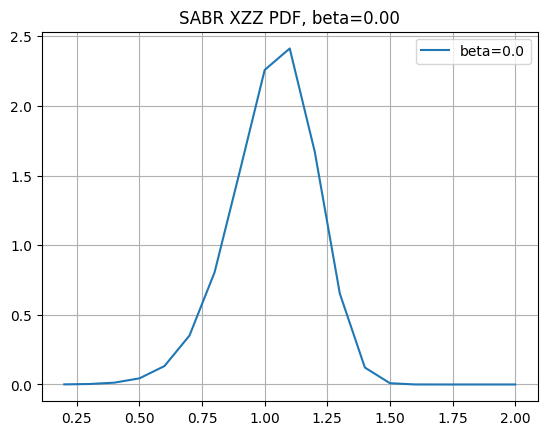

In [6]:
import numpy as np
from scipy.special import iv

Q_x = np.array([
    0.4,
    0.485,
    0.57,
    0.655,
    0.74,
    0.825,
    0.91,
    0.995,
    1.08,
    1.165,
    1.25,
    1.335,
    1.42,
    1.505,
    1.59,
    1.675,
    1.76,
    1.845,
    1.93,
    2.015,
    2.1
])

Q_H_y_3 = np.array([
    0.6350203,
    0.6041921,
    0.579231,
    0.5584657,
    0.5409,
    0.5258056,
    0.5127053,
    0.5012174,
    0.4910923,
    0.4820835,
    0.4740534,
    0.466857,
    0.4604359,
    0.4547031,
    0.4495232,
    0.4448568,
    0.4406356,
    0.4368164,
    0.4333387,
    0.4301594,
    0.4272637
])
Q_H_y_20 = np.array([
    0.446000,
    0.431400,
    0.419000,
    0.408500,
    0.399300,
    0.391300,
    0.384200,
    0.378000,
    0.372400,
    0.367300,
    0.362800,
    0.358700,
    0.355000,
    0.351700,
    0.348600,
    0.345800,
    0.343300,
    0.341000,
    0.338900,
    0.336900,
    0.335100
])
Q_L_y = np.array([
    0.649120,
    0.616192,
    0.589531,
    0.567466,
    0.548800,
    0.532806,
    0.519005,
    0.507017,
    0.496392,
    0.487084,
    0.478853,
    0.471557,
    0.465036,
    0.459203,
    0.454023,
    0.449257,
    0.445036,
    0.441216,
    0.437839,
    0.434759,
0.431864
])


#def sabr_implied_vol(K, F=1, T=3, alpha=0.5, beta=0.6, rho=-0.2, nu=0.3):
def sabr_implied_vol(K, T=20, F=1, alpha=0.5, beta=0.6, rho=-0.2, nu=0.3):
    """
    Computes the SABR-implied Black volatility using Hagan's approximation.
    
    Parameters:
        K (float): Strike price
        F (float): Forward price
        T (float): Time to maturity
        alpha (float): SABR volatility parameter
        beta (float): SABR elasticity parameter (0 <= beta <= 1)
        rho (float): SABR correlation parameter (-1 <= rho <= 1)
        nu (float): SABR volatility of volatility parameter

    Returns:
        float: The implied volatility (Black volatility)
    """
    
    K = np.asarray(K, dtype=np.float64)
    eps = 1e-07
    # Determine the ATM condition for each K
    atm = np.abs(F - K) < eps

    # ATM branch
    vol_atm = (alpha / (F**(1-beta))) * (
        1 + (
            ((1-beta)**2 / 24) * (alpha**2 / (F**(2-2*beta))) +
            (rho * beta * nu * alpha) / (4 * (F**(1-beta))) +
            ((2-3*rho**2) / 24) * nu**2
        ) * T
    )

    # Non-ATM branch
    log_fk = np.log(F / K)
    fk_beta = (F * K)**((1-beta)/2)
    z = (nu / alpha) * fk_beta * log_fk
    sqrt_expr = np.sqrt(1 - 2 * rho * z + z**2)
    x_z = np.where(
        np.abs(z) > eps,
        np.log((sqrt_expr + z - rho) / (1 - rho)),
        z - 0.5 * rho * z**2  # Series expansion for small z
    )
    term1 = ((1-beta)**2 / 24) * (alpha**2 / (fk_beta**2))
    term2 = (rho * beta * nu * alpha) / (4 * fk_beta)
    term3 = ((2-3*rho**2) / 24) * nu**2
    vol_nonatm = (alpha / (((F * K)**((1-beta)/2)) * (1 + ((1-beta)**2/24)*(log_fk**2) + ((1-beta)**4/1920)*(log_fk**4)))) \
                 * (z / x_z) * (1 + (term1 + term2 + term3) * T)

    vol = np.where(atm, vol_atm, vol_nonatm)
    # Return a scalar if input was scalar
    if vol.size == 1:
        return float(vol)
    return vol




def sabr_xzz_pdf(K, T=20, F=1, alpha=0.5, beta=0.5, rho=-0.2, nu=0.3):
    """
    Computes the SABR-implied Black volatility using Hagan's approximation.
    
    Parameters:
        K (float): Strike price
        F (float): Forward price
        T (float): Time to maturity
        alpha (float): SABR volatility parameter
        beta (float): SABR elasticity parameter (0 <= beta <= 1)
        rho (float): SABR correlation parameter (-1 <= rho <= 1)
        nu (float): SABR volatility of volatility parameter

    Returns:
        float: The implied volatility (Black volatility)
    """
    # Implementation details for the SABR XZZ model would go here
    r = 0.5/(1-beta)
    def Z(f):
        return f**(1-beta)/alpha/(1-beta)
    def J(z):
        return (1 - 2*rho*nu*z + (nu*z)**2)**0.5
    def X(z):
        return np.log((J(z) + z*nu - rho)/(1 - rho))/nu 
    def bessel(z):
        return iv(r, z)
    def K1(z):
        zf = Z(K) + z
        return 1/8*(2-3*(rho-nu*z)**2/J(z)**2)*nu*nu-1/4*rho*beta*nu/(1-beta)/zf
    def K2(z):
        zf = Z(K) + z
        return -beta*(2-beta)/8/(1-beta)**2/(zf**2)
    
    if(beta ==1):
        z = np.log(F/K)/alpha
    else:
        z = Z(F)-Z(K)
    def h(z):
        rho_=np.sqrt(1-rho*rho)
        return 1/2*beta*rho/(1-beta)/J(-Z(K))**2*(nu*Z(K)*np.log(Z(K)*J(z)/Z(F))+(1+rho*nu*Z(K))/rho_*(np.arctan((nu*z-rho)/rho_)+np.arctan(rho/rho_)))
    
    if (beta == 0):
        pdf = 1/(alpha*K**beta)*J(z)**(-1.5)/np.sqrt(2*np.pi*T)*np.sqrt(F**beta/K**beta)*np.exp(-X(z)**2/2/T)
    if beta ==1:
        pdf = 1/(alpha*J(z)**(-1.5)*np.sqrt(2*np.pi*T*F*K))*np.exp(-X(z)**2/2/T)
    else:
        pdf = 1/(alpha*K**beta)*J(z)**(-1.5)/T*Z(F)**r*Z(K)**(1-r)*bessel(Z(F)*Z(K)/T)*np.exp(-X(z)**2/2/T-Z(F)*Z(K)/T+h(z)+(K1(z/2))*T)
    return pdf


from scipy.integrate import quad
def integrate_pdf(T=20, F=1, alpha=0.5, beta = 0.5, rho=-0.2, nu=0.3):
    integrand = lambda K: sabr_xzz_pdf(K, T=T, F=F, alpha=alpha, beta=beta, rho=rho, nu=nu)*K
    result, error = quad(integrand, 0, 10*F, limit=2000)
    return result, error


def call_price_sabr(K, T, F, alpha, beta, rho, nu,scale):
    # K can be an array, so we need to return an array of call prices
    # Use np.vectorize to apply integration for each strike K
    def integrand(f, K_):
        return sabr_xzz_pdf(f, T, F, alpha, beta, rho, nu) * scale * np.maximum(f - K_, 0)
    # Vectorized integration for each K in K_values
    if isinstance(K, np.ndarray):
        call_prices = np.array([
            quad(integrand, 0, 10*F, args=(k,), limit=2000)[0] for k in K
        ])
        return call_prices
    else:
        call_price, _ = quad(integrand, 0, 10*F, args=(K,), limit=2000)
        return call_price

from scipy.stats import norm
from scipy.optimize import brentq
def black_scholes_call(S, K, T, r, sigma):
    """
    Calculates the Black-Scholes price for a European call option.

    Args:
        S (float): The current price of the underlying asset.
        K (float): The strike price of the option.
        T (float): The time to expiration in years.
        r (float): The risk-free interest rate.
        sigma (float): The volatility of the underlying asset.

    Returns:
        float: The price of the call option.
    """
    # d1 and d2 are intermediate values used in the Black-Scholes formula
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    # Calculate the call option price
    call_price = (S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2))
    return call_price

def vega(S, K, T, r, sigma):
    """
    Calculates the Vega of an option. Vega measures the sensitivity of an 
    option's price to changes in the volatility of the underlying asset.

    Args:
        S (float): The current price of the underlying asset.
        K (float): The strike price of the option.
        T (float): The time to expiration in years.
        r (float): The risk-free interest rate.
        sigma (float): The volatility of the underlying asset.

    Returns:
        float: The Vega of the option.
    """
    # d1 is an intermediate value used in the Black-Scholes formula
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    
    # Calculate Vega
    vega = S * norm.pdf(d1) * np.sqrt(T)
    return vega

def implied_volatility(call_price, S, K, T, r):
    """
    Calculates the implied volatility for a European call option.

    Args:
        call_price (float): The market price of the call option.
        S (float): Current stock price.
        K (float): Strike price.
        T (float): Time to maturity.
        r (float): Risk-free interest rate.

    Returns:
        float: The implied volatility.
    """
    try:
        # Objective function: difference between Black-Scholes price and market price
        def objective_function(sigma):
            return black_scholes_call(S, K, T, r, sigma) - call_price

        # Use Brent's method to find the root (the implied volatility)
        # We provide a reasonable bracket for volatility [0.001, 2.0]
        return brentq(objective_function, 1e-3, 2.0)
    except ValueError:
        # If the solver fails, it may be because the price is outside the no-arbitrage bounds
        return np.nan
    

import matplotlib.pyplot as plt

K_values = np.linspace(0.1, 2, 20)

betas = np.arange(0., 1.0, 10)
F = 1.0
T = .5
alpha0 = 0.25
beta = 0.6
nu = 0.3
rho = -0.8
integral = integrate_pdf(T=T, F=F, alpha=alpha0, beta=beta, rho=rho, nu=nu)[0]
scale = F/integral
price = call_price_sabr(K_values, T=T, F=F, alpha=alpha0, beta=beta, rho=rho, nu=nu, scale=scale)
# Calculate implied volatility for a range of strike prices
for k, p in zip(K_values, price):
    v = implied_volatility(call_price=p, S=F, K=k, T=T, r=0.0)
    print(f"Strike: {k:.4f}, Price: {p:.6f}, Vol: {v:.6f}")
# Plot the call prices

for beta in betas:
    vols_beta = sabr_xzz_pdf(K_values, T=T, F=F, alpha=alpha0, beta=beta, rho=rho, nu=nu)*K_values
    plt.figure()
    plt.plot(K_values[1:], vols_beta[1:], label=f'beta={beta:.1f}')
    plt.title(f"SABR XZZ PDF, beta={beta:.2f}")
    
    # Integrate sabr_xzz_pdf over K_values for the given beta
    integral = integrate_pdf(T=T, F=F, alpha=alpha0, beta=beta, rho=rho, nu=nu)
    print(f"Integral of sabr_xzz_pdf over K_values for beta={beta}: {integral}")
plt.legend()
plt.grid(True)
plt.show()

In [7]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

# --- Assume functions from previous sections are defined: ---
# normalize_data(data, qh_min, qh_max)
# denormalize_data(normalized_data, qh_min, qh_max)
# compile_input_table(hf_y, hf_q_l, lf_y, lf_q)
# build_mda_cnn(input_table_shape, num_filters=64, kernel_size=3, dnn_hidden_units=10)
# ---------------------------------------------------------

# Step 5a: Generate Synthetic Data
def Q_L(y):
  """Low-fidelity function (e.g., sine wave)."""
  return np.sin(8*np.pi*y)
  #q = 0.5*(6*y-2)**2*np.sin(12 * y-4) +10*(y-0.5)-5
  #return q
  #return np.where(y <= 0.5, q, q + 3)
  #return np.sin(2 * np.pi * y) + (y - 0.5) # Example with more structure
  #return np.sin(2 * np.pi * y) - 0.5 * (y - 0.5) # Example with more structure
def Q_H(y):
  """High-fidelity function (e.g., LF + correction term)."""
  #return (6*y-2)**2*np.sin(12 * y-4) -10*(y-1)**2
  # q = 2*Q_L(y)-20*y+20
  # return np.where(y <= 0.5, q, q + 4)
  #return np.sin(y) + 0.1 * np.sin(10 * y)
  #return (y - np.sqrt(2)) * Q_L(y)**2 # Alternative example
  return y**2+ Q_L(y+np.pi/10)**2 # Alternative example
  #return Q_L(y) * 1.2 + 0.1 * np.cos(10 * np.pi * y) + 0.1*y # Example related to Q_L

# Define data ranges and sizes
y_min, y_max = 0, 1
n_l_samples = 100  # Number of low-fidelity samples
n_h_samples = 10   # Number of high-fidelity samples (sparse)

# Generate LF data (dense grid)
lf_y_all = np.linspace(y_min, y_max, n_l_samples)

lf_q_all = Q_L(lf_y_all)

# Generate HF data (sparse, randomly sampled)
# Ensure HF points are within the LF range for interpolation later
hf_y_train = np.linspace(y_min, y_max, n_h_samples)
#hf_y_train = np.sort(np.random.uniform(y_min, y_max, n_h_samples))
hf_q_train = Q_H(hf_y_train)
hf_q_l_train = Q_L(hf_y_train)

# test sabr
Q_H_y = Q_H_y_3  # Use the 20-year high-fidelity data for testing
T = 3
y_min, y_max = 0.4, 2.1
n_l_samples = 40
n_h_samples = 5

lf_y_all = np.linspace(y_min-0.1, y_max+0.5, n_l_samples)
#lf_y_all = np.random.uniform(y_min-0.1, y_max+0.5, n_l_samples)

lf_q_all = sabr_implied_vol(lf_y_all,T)

# lf_y_all = Q_x
# lf_q_all = Q_L_y
# n_l_samples = len(lf_y_all)

# Randomly pick 5 indices from lf_y_all
# Always include the first (0) and last (len(Q_x)-1) indices, then randomly pick the remaining
remaining_indices = np.setdiff1d(np.arange(len(Q_x)), [0, len(Q_x)-1])
rand_indices_rest = np.random.choice(remaining_indices, size=n_h_samples-2, replace=False)
rand_indices = np.concatenate(([0], rand_indices_rest, [len(Q_x)-1]))

#rand_indices = np.random.choice(np.arange(len(Q_x)), size=n_h_samples, replace=False)
rand_indices = np.linspace(0, len(Q_x)-1, n_h_samples, dtype=int)

hf_y_train = Q_x[rand_indices]
hf_q_train0 = Q_H_y[rand_indices]
#hf_q_l_train = Q_L_y[rand_indices]
hf_q_l_train = sabr_implied_vol(hf_y_train,T)
hf_q_train = hf_q_train0-hf_q_l_train



print(f"Generated {n_l_samples} LF samples.")
print(f"Generated {n_h_samples} HF samples for training.")

# Step 5b: Calculate HF Range for Normalization
qh_min = np.min(hf_q_train)
qh_max = np.max(hf_q_train)
#qh_min = np.min(lf_q_all)
#qh_max = np.max(lf_q_all)
print(f"HF Training Data Range (Q_H): min={qh_min:.4f}, max={qh_max:.4f}")

# Step 5c: Normalize Data
# Normalize HF training outputs (target variable)
y_train_normalized = normalize_data(hf_q_train, qh_min, qh_max)

# Normalize ALL LF outputs using the HF range
lf_q_all_normalized = normalize_data(lf_q_all, qh_min, qh_max)

print("Normalized HF and LF data using HF range.")

# Step 5d: Compile Input Tables for Training
X_train_list =[]
for i in range(n_h_samples):
  hf_y_i = hf_y_train[i]

  # Get the corresponding LF prediction AT hf_y_i.
  # Since lf_y_all is a dense grid, we can interpolate.
  # IMPORTANT: Use the *normalized* LF data for interpolation here.
  
  #hf_q_l_i_normalized = np.interp(hf_y_i, lf_y_all, lf_q_all_normalized)
  hf_q_l_i_normalized = normalize_data(hf_q_l_train[i], qh_min, qh_max)

  # Compile the table for this HF point using the full LF dataset context
  table_i = compile_input_table(hf_y_i, hf_q_l_i_normalized, lf_y_all, lf_q_all_normalized)
  X_train_list.append(table_i)

# Stack the tables to create the training input tensor
# Shape: (N_H, N_L, C) -> (n_h_samples, n_l_samples, 4) for 1D case
X_train = np.array(X_train_list)
y_train = y_train_normalized # Target variable

print(f"Compiled training input X_train with shape: {X_train.shape}")
print(f"Training target y_train with shape: {y_train.shape}")

# Step 5e: Build the Model
input_table_shape = X_train.shape[1:] # (N_L, C)
model = build_mda_cnn(input_table_shape, num_filters=32, kernel_size=3, dnn_hidden_units=5) # Example: Adjusted hyperparameters
model.summary()

# Step 5f: Train the Model
print("\nStarting model training...")
history = model.fit(X_train, y_train,
                    epochs=2600, # Adjust epochs as needed
                    batch_size=32, # Adjust batch size based on N_H
                    verbose=1) # Set verbose=1 or 2 to see progress
print("Model training complete.")
print(f"Final training loss: {history.history['loss'][-1]:.4f}")

# Step 5g: Prediction Example
# Choose a new point for prediction (not in hf_y_train)
y_pred_point = 0.65

# 1. Get LF prediction at the new point
lf_q_pred = Q_L(y_pred_point)

# 2. Normalize the LF prediction using the SAME HF range
lf_q_pred_normalized = normalize_data(lf_q_pred, qh_min, qh_max)

# 3. Compile the input table for the prediction point.
#    *** CRITICAL: Use the original full lf_y_all and lf_q_all_normalized ***
#    The model relies on the context learned from this specific LF dataset.
# Compile the input table for the prediction point
X_pred_table = compile_input_table(y_pred_point, lf_q_pred_normalized, lf_y_all, lf_q_all_normalized)

# Debug: Print the shape of the prediction table
print(f"X_pred_table shape: {X_pred_table.shape}")

# Reshape the table for model prediction (add batch dimension)
X_pred_input = np.expand_dims(X_pred_table, axis=0)  # Shape: (1, N_L, C)

# Debug: Print the shape of the input to the model
print(f"X_pred_input shape: {X_pred_input.shape}")

# Make the prediction (output is normalized)
y_pred_normalized = model.predict(X_pred_input)

# Debug: Print the normalized prediction
print(f"y_pred_normalized: {y_pred_normalized}")

# Denormalize the prediction to get the final value
y_pred_denormalized = denormalize_data(y_pred_normalized, qh_min, qh_max)

# Debug: Print the denormalized prediction
print(f"y_pred_denormalized: {y_pred_denormalized}")

# Compare with true value
true_q_h_at_pred = Q_H(y_pred_point)

print(f"\nPrediction at y = {y_pred_point:.4f}:")
print(f"  Normalized LF prediction (hf_q_l_norm): {lf_q_pred_normalized:.4f}")
print(f"  Model normalized output (y_pred_norm): {y_pred_normalized[0][0]:.4f}")
print(f"  Denormalized Prediction (Q_H_pred): {y_pred_denormalized[0][0]:.4f}")
print(f"  True High-Fidelity Value (Q_H_true): {true_q_h_at_pred:.4f}")
print(f"  Prediction Error: {abs(y_pred_denormalized[0][0] - true_q_h_at_pred):.4f}")


Generated 40 LF samples.
Generated 5 HF samples for training.
HF Training Data Range (Q_H): min=-0.0141, max=-0.0044
Normalized HF and LF data using HF range.
hf_y: 0.4, hf_y shape: ()
lf_y shape: (40,), lf_q shape: (40,)
lf_y_arr shape: (40, 1), lf_q_arr shape: (40, 1)
hf_y_repeated shape: (40, 1), hf_q_l_repeated shape: (40, 1)
input_table shape: (40, 4)
hf_y: 0.825, hf_y shape: ()
lf_y shape: (40,), lf_q shape: (40,)
lf_y_arr shape: (40, 1), lf_q_arr shape: (40, 1)
hf_y_repeated shape: (40, 1), hf_q_l_repeated shape: (40, 1)
input_table shape: (40, 4)
hf_y: 1.25, hf_y shape: ()
lf_y shape: (40,), lf_q shape: (40,)
lf_y_arr shape: (40, 1), lf_q_arr shape: (40, 1)
hf_y_repeated shape: (40, 1), hf_q_l_repeated shape: (40, 1)
input_table shape: (40, 4)
hf_y: 1.675, hf_y shape: ()
lf_y shape: (40,), lf_q shape: (40,)
lf_y_arr shape: (40, 1), lf_q_arr shape: (40, 1)
hf_y_repeated shape: (40, 1), hf_q_l_repeated shape: (40, 1)
input_table shape: (40, 4)
hf_y: 2.1, hf_y shape: ()
lf_y shape

Model: "MDA_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_Table (InputLayer)        │ (None, 40, 4)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1D_Layer0 (Conv1D)          │ (None, 40, 32)         │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1D_Layer1 (Conv1D)          │ (None, 20, 32)         │         3,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Flatten_Layer (Flatten)         │ (None, 640)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden_1 (Dense)          │ (None, 5)              │         3,205 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_Hidden_2 (Dense)          │ (None, 5)              │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer_3 (Dense)           │ (None, 5)              │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,791 (26.53 KB)

 Trainable params: 6,791 (26.53 KB)

 Non-trainable params: 0 (0.00 B)


Starting model training...
Epoch 1/2600
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 1.8363 - mean_absolute_error: 1.2899
Epoch 2/2600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 1.1441 - mean_absolute_error: 0.9763
Epoch 3/2600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.6855 - mean_absolute_error: 0.7426
Epoch 4/2600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.5566 - mean_absolute_error: 0.6787
Epoch 5/2600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.5040 - mean_absolute_error: 0.6533
Epoch 6/2600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.4570 - mean_absolute_error: 0.6289
Epoch 7/2600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.4142 - mean_absolute_error: 0.6045
Epoch 8/2600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.3721 - mean_absolute_error: 0.5788
Epoch 9/2600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.3286 - mean_absolute_error: 0.5497
Epoch 10/2600
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.2867 - mean_absolute_error: 0.5186
Epoch 11/2600

hf_y: 0.4, hf_y shape: ()
lf_y shape: (40,), lf_q shape: (40,)
lf_y_arr shape: (40, 1), lf_q_arr shape: (40, 1)
hf_y_repeated shape: (40, 1), hf_q_l_repeated shape: (40, 1)
input_table shape: (40, 4)
y_p: 0.4, table_p shape: (40, 4), input_p shape: (1, 40, 4)
hf_y: 0.485, hf_y shape: ()
lf_y shape: (40,), lf_q shape: (40,)
lf_y_arr shape: (40, 1), lf_q_arr shape: (40, 1)
hf_y_repeated shape: (40, 1), hf_q_l_repeated shape: (40, 1)
input_table shape: (40, 4)
y_p: 0.485, table_p shape: (40, 4), input_p shape: (1, 40, 4)
hf_y: 0.57, hf_y shape: ()
lf_y shape: (40,), lf_q shape: (40,)
lf_y_arr shape: (40, 1), lf_q_arr shape: (40, 1)
hf_y_repeated shape: (40, 1), hf_q_l_repeated shape: (40, 1)
input_table shape: (40, 4)
y_p: 0.57, table_p shape: (40, 4), input_p shape: (1, 40, 4)
hf_y: 0.655, hf_y shape: ()
lf_y shape: (40,), lf_q shape: (40,)
lf_y_arr shape: (40, 1), lf_q_arr shape: (40, 1)
hf_y_repeated shape: (40, 1), hf_q_l_repeated shape: (40, 1)
input_table shape: (40, 4)
y_p: 0.655, 

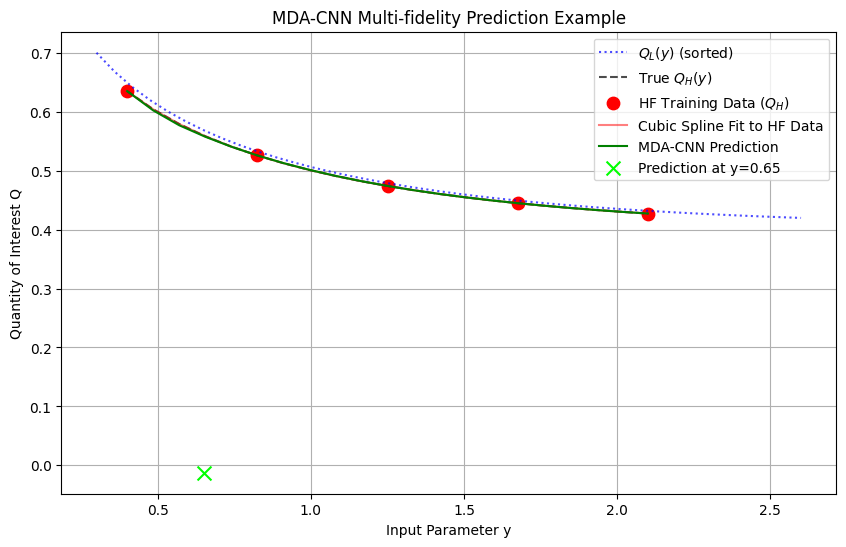

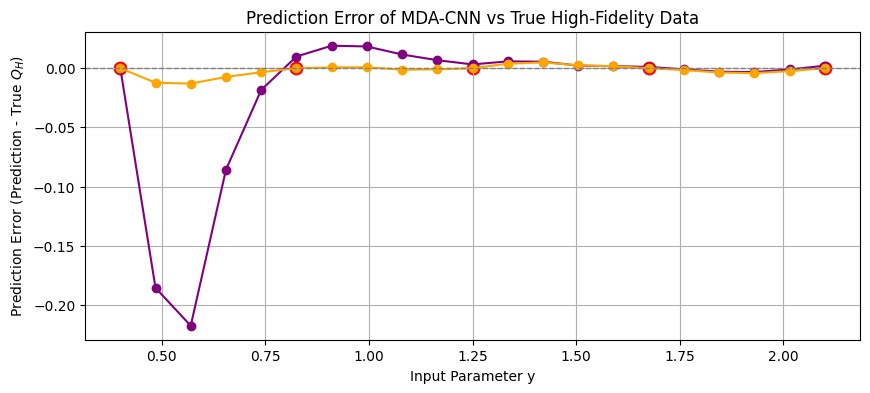

In [8]:
# fit hf_y_train, hf_q_train using cubic spline interpolation
# Sort hf_y_train and hf_q_train so the x-values are strictly increasing
sort_idx = np.argsort(hf_y_train)
hf_y_train_sorted = hf_y_train[sort_idx]
hf_q_train_sorted = hf_q_train[sort_idx]

# Create a cubic spline interpolator for the high-fidelity data
cs = CubicSpline(hf_y_train_sorted, hf_q_train_sorted)
# Generate a dense grid of points for plotting
y_dense = Q_x
# Evaluate the spline on the dense grid
hf_q_dense = cs(y_dense)+ sabr_implied_vol(y_dense,T)

#y_plot = np.linspace(y_min, y_max, 200)
y_plot = Q_x
# Optional: Plot results
plt.figure(figsize=(10, 6))
#plt.plot(y_plot, Q_H(y_plot), 'k--', label='True $Q_H(y)$', alpha=0.7)
# Sort lf_y_all and lf_q_all together based on lf_y_all for plotting
lf_sort_idx = np.argsort(lf_y_all)
lf_y_all_sorted = lf_y_all[lf_sort_idx]
lf_q_all_sorted = lf_q_all[lf_sort_idx]
plt.plot(lf_y_all_sorted, lf_q_all_sorted, 'b:', label='$Q_L(y)$ (sorted)', alpha=0.7)

#plt.plot(lf_y_all, lf_q_all, 'b:', label='$Q_L(y)$', alpha=0.7)
plt.plot(y_plot, Q_H_y, 'k--', label='True $Q_H(y)$', alpha=0.7)
plt.scatter(hf_y_train, hf_q_train0, c='r', marker='o', s=80, label='HF Training Data ($Q_H$)')

plt.plot(y_dense, hf_q_dense, 'r-', label='Cubic Spline Fit to HF Data', alpha=0.5)
# Generate predictions across the domain for visualization

q_h_pred_plot = []
for i , y_p in  enumerate(y_plot):
    lf_q_p = sabr_implied_vol(y_p, T)
    #lf_q_p = lf_q_all[i]  # Low-fidelity prediction at y_p
    lf_q_p_norm = normalize_data(lf_q_p, qh_min, qh_max)
    table_p = compile_input_table(y_p, lf_q_p_norm, lf_y_all, lf_q_all_normalized)
    input_p = np.expand_dims(table_p, axis=0)

    # Debug: Print shapes during the loop
    print(f"y_p: {y_p}, table_p shape: {table_p.shape}, input_p shape: {input_p.shape}")

    pred_norm = model.predict(input_p, verbose=0)
    pred_denorm = denormalize_data(pred_norm, qh_min, qh_max)
    pred_denorm += lf_q_p
    q_h_pred_plot.append(pred_denorm[0][0])  # Append the scalar value




plt.plot(y_plot, q_h_pred_plot, 'g-', label='MDA-CNN Prediction')
plt.scatter([y_pred_point], [y_pred_denormalized], c='lime', marker='x', s=100, zorder=5, label=f'Prediction at y={y_pred_point:.2f}')

plt.xlabel('Input Parameter y')
plt.ylabel('Quantity of Interest Q')
plt.title('MDA-CNN Multi-fidelity Prediction Example')
plt.legend()
plt.grid(True)
#plt.ylim(min(np.min(Q_H(lf_y_all)), np.min(lf_q_all)) - 0.2, max(np.max(Q_H(lf_y_all)), np.max(lf_q_all)) + 0.2) # Adjust ylim for better view
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(y_plot, 100*(np.array(q_h_pred_plot) - Q_H_y), marker='o', linestyle='-', color='purple', label='MDA-CNN Prediction Error ($Q_H - Q_H$)')
plt.plot(y_plot, 100*(hf_q_dense - Q_H_y), marker='o', linestyle='-', color='orange', label='Cubic Spline Fit Error')
#plt.plot(y_plot, 100*(Q_L_y - Q_H_y), marker='x', linestyle='-', color='blue', label='Low-Fidelity Prediction Error ($Q_L - Q_H$)')

plt.scatter(hf_y_train, 100*(hf_q_train - hf_q_train), c='r', marker='o', s=80, label='HF Training Data ($Q_H$)')

plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.xlabel('Input Parameter y')
plt.ylabel('Prediction Error (Prediction - True $Q_H$)')
plt.title('Prediction Error of MDA-CNN vs True High-Fidelity Data')
plt.grid(True)
plt.show()